# Домашнее задание 4

## Скачиваю датасет

In [205]:
import requests
import zipfile
import io
import pandas as pd

url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
response = requests.get(url)

zip_file_in_memory = io.BytesIO(response.content)
zip_ref = zipfile.ZipFile(zip_file_in_memory, 'r')
zipzipzip = zip_ref.read("bank.zip")
zipzip = io.BytesIO(zipzipzip)
csv_zip = zipfile.ZipFile(zipzip,'r')
csv_file = csv_zip.open("bank-full.csv")


## Подключаем библиотеки

In [206]:
import numpy as np
import matplotlib.pyplot as plt

## Выводим первые 5 строк

In [207]:
df = pd.read_csv(csv_file, sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Проверяю типы колонок

In [208]:
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


## Просматриваю те ли у меня данные, которые мне нужны и проверяю нет ли пустых строк

In [209]:
priznaki =  """age,
job,
marital,
education,
balance,
housing,
contact,
day,
month,
duration,
campaign,
pdays,
previous,
poutcome,
y"""
pr = priznaki.replace(",", "").split('\n')
for col in df.columns:
  if col not in pr:
    df = df.drop(col, axis=1)

df.isnull().sum()


,0
age,0
job,0
marital,0
education,0
balance,0
housing,0
contact,0
day,0
month,0
duration,0


# Вопрос 1
Какое самое частое значение (mode) для столбца education?<br><br>

unknown<br>
primary<br>
secondary<br>
tertiary<br>

In [210]:

chasto = df['education'].mode()
print(f'''


Ответ: {chasto[0]}

''')




Ответ: secondary




# Вопрос 2

Создайте корреляционную матрицу для числовых признаков вашего датасета.
В корреляционной матрице вычислите коэффициент корреляции между каждой парой признаков.
<br>
Какие два признака имеют наибольшую корреляцию?
<br>

age и balance<br>
day и campaign<br>
day и pdays<br>
pdays и previous<br>

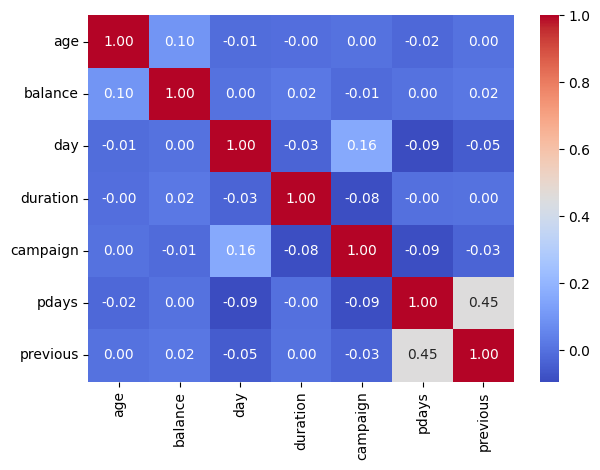

In [211]:
import seaborn as sns
dfint64 = df
for col in dfint64.columns:
  if dfint64[col].dtype != 'int64':
    dfint64 = dfint64.drop(col, axis=1)
correlation_matrix = dfint64.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.tight_layout()
plt.show()


In [212]:

cor = correlation_matrix.stack()
cor = cor[cor != 1.0]
ind = cor.idxmax()
print(f'''
Ответ: {ind[0]} и {ind[1]} = {cor.max()}
''')



Ответ: pdays и previous = 0.4548196354805043



### Далее, так как `y` у нас категориальные значения имеет, то мы заменяем yes/no на 1/0

In [213]:
df['y'] = np.where(df['y'] == 'yes', 1, 0)

## Обучаю модель

In [214]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder

X = df.drop('y', axis=1)
y = df['y']

X_train, X_temp, y_train, y_temp = train_test_split(X, y,
                                                    test_size=0.4,
                                                    random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                                test_size=0.5,
                                                random_state=42)

print(f"X_train: {X_train.shape} (60%)")
print(f"X_val:   {X_val.shape} (20%)")
print(f"X_test:  {X_test.shape} (20%)")

X_train: (27126, 14) (60%)
X_val:   (9042, 14) (20%)
X_test:  (9043, 14) (20%)


# Вопрос 3
Рассчитайте взаимную информацию (mutual_info_classif) между y и другими категориальными переменными в датасете. Используйте только тренировочный набор.
Округлите результаты до двух знаков после запятой с помощью round(score, 2).
Какая из этих переменных имеет наибольшую взаимную информацию?<br>

contact<br>
education<br>
housing<br>
poutcome<br>

In [215]:
categorical_cols = X_train.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder()
X_train_categorical = X_train[categorical_cols].copy()
X_train_categorical_encoded = encoder.fit_transform(X_train_categorical)

mi_scores = mutual_info_classif(X_train_categorical_encoded, y_train,
                                discrete_features=True)

mi_series = pd.Series(mi_scores, index=categorical_cols)
mi_series_rounded = mi_series.round(2)

print(mi_series_rounded.sort_values(ascending=False))


print(f'''
Ответ: {mi_series_rounded.idxmax()}''')

poutcome     0.03
month        0.02
job          0.01
contact      0.01
housing      0.01
education    0.00
marital      0.00
dtype: float64

Ответ: poutcome


In [216]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
X_train = pd.get_dummies(X_train, columns=categorical_cols)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# Вопрос 4

Какую точность вы получили?

In [217]:
from sklearn.metrics import accuracy_score
X_val = pd.get_dummies(X_val, columns=categorical_cols)
pred = model.predict(X_val)
accuracy = np.round(accuracy_score(y_val, pred), 2)
print(f'''
Oтвет: {accuracy}
''')



Oтвет: 0.9



In [218]:
test_features = ["age", "balance", "marital", "previous"]

feature_columns = {}

for feature in test_features:
    if feature in X_train.columns:
        feature_columns[feature] = [feature]
    else:
        feature_columns[feature] = [col for col in X_train.columns if col.startswith(feature + "_")]

feature_columns

{'age': ['age'],
 'balance': ['balance'],
 'marital': ['marital_divorced', 'marital_married', 'marital_single'],
 'previous': ['previous']}

In [219]:
diff = {}

for feature, cols in feature_columns.items():
    X_train_temp = X_train.drop(columns=cols)
    X_val_temp = X_val.drop(columns=cols)

    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train_temp, y_train)
    pred = model.predict(X_val_temp)

    acc_new = accuracy_score(y_val, pred)

    diff[feature] = accuracy - acc_new

s = pd.Series(diff)
d = s.to_frame('Diff')
d.head()

,Diff
age,-0.001017
balance,-0.000796
marital,-0.000575
previous,0.000088


# Вопрос 5
Какой из следующих признаков имеет наименьшую разницу?

age
balance
marital
previous

In [220]:
col = d['Diff']
min_feature = col.idxmin()
min_value = col.min()
print(f'Ответ: {min_feature} = {min_value}')

Ответ: age = -0.0010174740101747126


In [221]:
C_values = [0.01, 0.1, 1, 10]

res = {}

for C in C_values:
    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    accuracy = np.round(accuracy_score(y_val, pred), 3)
    res[C] = accuracy

In [222]:
sr = pd.Series(res)
dr = s.to_frame('RES')
dr.head()

,RES
age,-0.001017
balance,-0.000796
marital,-0.000575
previous,0.000088


# Вопрос 6

Теперь давайте обучим регуляризованную логистическую регрессию.
Попробуем следующие значения параметра C: [0, 0.01, 0.1, 1, 10].
Обучите модели с использованием всех признаков, как в 4 вопросе.
Рассчитайте точность на валидационном наборе данных и округлите ее до трех знаков после запятой.
Какое из значений C приводит к наилучшей точности на валидационном наборе?<br>

0.01<br>
0.1<br>
1<br>
10<br>
100<br>

In [223]:
max(res.items(), key=lambda x: x[1])

(0.1, np.float64(0.901))

Ответ: 0.1

# Ответы:
### 1. Ответ: `secondary`
### 2. Ответ: `pdays и previous = 0.4548196354805043`
### 3. Ответ: `poutcome`
### 4. Oтвет: `0.9`
### 5. Ответ: `age = -0.0010174740101747126`
### 6. Ответ: `0.1`